<a href="https://colab.research.google.com/github/yohanesnuwara/geostatistics/blob/main/project_notebooks/integrated_dashboarding_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up

In [ ]:
!git clone https://github.com/yohanesnuwara/geostatistics
!git clone https://github.com/yohanesnuwara/formation-evaluation

Cloning into 'geostatistics'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 344 (delta 5), reused 0 (delta 0), pack-reused 329
Receiving objects: 100% (344/344), 96.45 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Checking out files: 100% (66/66), done.
Cloning into 'formation-evaluation'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 157 (delta 73), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (157/157), 10.58 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [ ]:
!pip install lasio
!pip install wellpathpy

     |████████████████████████████████| 215kB 6.2MB/s 


In [ ]:
import glob, sys, os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import seaborn as sns
from bs4 import BeautifulSoup
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
import wellpathpy as wp
import lasio

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, ToggleButtons
import ipywidgets as widgets

import sys
sys.path.append("/content/formation-evaluation")
from label_generator import label_generator

pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.style.use("classic")

# In-house Functions

# Trajectory Data

## Open file

In [ ]:
def open_xml_trajectory(path):
  # Reading the WITSML file
  with open(path) as file:
    data = file.read()

  # Parse the WITSML file using the Beautiful library
  soup = BeautifulSoup(data, 'xml')

  # Convert to Pandas dataframe
  data = soup.find_all('data')

  # Print all tags (column names)
  colnames = set([str(tag.name) for tag in soup.find_all()])

  # Convert into dataframe with only selected column names
  columns = ['azi', 'md', 'tvd', 'incl', 'dispNs', 'dispEw']
  df = pd.DataFrame()
  for col in columns:
      df[col] = [float(x.text) for x in soup.find_all(col)]

  return df

In [ ]:
path = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/trajectory2.xml"

traj_df = open_xml_trajectory(path)

traj_df.head(10)

,azi,md,tvd,incl,dispNs,dispEw
0,0.00,0.0,0.0000,0.00,-3.1700,3.5300
1,0.00,145.9,145.9000,0.00,-3.1700,3.5300
2,253.69,153.4,153.4000,0.15,-3.1728,3.5206
3,146.02,234.2,234.1996,0.28,-3.3662,3.5294
4,136.21,274.6,274.5978,0.78,-3.6465,3.7749
5,128.29,315.0,314.9898,1.46,-4.1640,4.3691
6,124.07,355.3,355.2515,3.41,-5.1536,5.7651
7,126.98,395.7,395.5379,5.13,-6.9133,8.2034
8,139.07,436.1,435.7648,5.52,-9.4680,10.9194
9,152.33,474.4,473.8855,5.62,-12.5207,12.9971


## Convert to true Northing-Easting 

In [ ]:
def trajectory_trueNE(df, md_column, inc_column, azi_column, 
                      surface_northing, surface_easting):
  md, inc, azi = df[md_column], df[inc_column], df[azi_column]
  # Calculate TVD, northing, easting, dogleg severity
  tvd, northing, easting, dls = wp.mincurve.minimum_curvature(md, inc, azi)
  # Calculate true northing and easting by shifting to the wellhead loc
  tvd, new_northing, new_easting = wp.location.loc_to_wellhead(tvd, northing, easting,
                                                              surface_northing, 
                                                              surface_easting)
  df["TVD_calc"] = tvd 
  df["surfNs"] = new_northing
  df["surfEw"] = new_easting
  return df

In [ ]:
# Wellhead location
surface_easting = 435053.55
surface_northing = 6478560.36

trajectory_trueNE(traj_df, "md", "incl", "azi", 
                       surface_northing, surface_easting)

traj_df.head(10)

,azi,md,tvd,incl,dispNs,dispEw,TVD_calc,surfNs,surfEw
0,0.00,0.0,0.0000,0.00,-3.1700,3.5300,0.000000,6.478560e+06,435053.550000
1,0.00,145.9,145.9000,0.00,-3.1700,3.5300,145.900000,6.478560e+06,435053.550000
2,253.69,153.4,153.4000,0.15,-3.1728,3.5206,153.399991,6.478560e+06,435053.540578
3,146.02,234.2,234.1996,0.28,-3.3662,3.5294,234.199630,6.478560e+06,435053.549412
4,136.21,274.6,274.5978,0.78,-3.6465,3.7749,274.597780,6.478560e+06,435053.794881
5,128.29,315.0,314.9898,1.46,-4.1640,4.3691,314.989847,6.478559e+06,435054.389145
6,124.07,355.3,355.2515,3.41,-5.1536,5.7651,355.251543,6.478558e+06,435055.785053
7,126.98,395.7,395.5379,5.13,-6.9133,8.2034,395.537936,6.478557e+06,435058.223387
8,139.07,436.1,435.7648,5.52,-9.4680,10.9194,435.764783,6.478554e+06,435060.939355
9,152.33,474.4,473.8855,5.62,-12.5207,12.9971,473.885535,6.478551e+06,435063.017149


## Visualization

In [ ]:
def visualize_trajectory(df, x, y, z):
  fig = px.line_3d(df, x=x, y=y, z=z)
  fig.update_scenes(zaxis_autorange="reversed")
  fig.show()

In [ ]:
visualize_trajectory(traj_df, "surfEw", "surfNs", "TVD_calc")

# Marker Data

## Formation tops

In [ ]:
# Path to well tops
topfile = "https://raw.githubusercontent.com/yohanesnuwara/volve-machine-learning/main/Volve_well_picks_modified.csv"

top_df = pd.read_csv(topfile)
top_df.head()

,WELL,PICKS,OBS,QLF,DEPTH,TVD,TVDSS,TWT,DIP,AZI,EASTING,NORTHING,INTRP
0,NO 15/9-11,Seabed,1,NaN,113.0,113.00,-88.00,93.93,NaN,NaN,435410.8,6474001.6,STAT
1,NO 15/9-11,NORDLAND GP. Top,1,NaN,586.0,586.00,-561.00,629.45,NaN,NaN,435409.4,6474001.9,STAT
2,NO 15/9-11,Utsira Fm. Top,1,NaN,825.0,824.99,-799.99,869.89,NaN,NaN,435409.1,6474003.9,STAT
3,NO 15/9-11,HORDALAND GP. Top,1,NaN,1099.0,1098.96,-1073.96,1126.03,NaN,NaN,435412.3,6474005.4,STAT
4,NO 15/9-11,Ty Fm. Top,1,NaN,2387.0,2386.71,-2361.71,2298.79,3.18,19.0,435422.4,6473986.8,STAT


In [ ]:
# Select tops of well 15/9-F-15 
top_df = top_df[top_df["WELL"].str.contains("15/9-F-15")]

# Make columns only consists of PICKS and DEPTH
top_df = top_df[["PICKS", "DEPTH"]].reset_index(drop=True)

top_df.head()

,PICKS,DEPTH
0,Seabed,146.00
1,NORDLAND GP. Top,146.00
2,Utsira Fm. Top,901.27
3,HORDALAND GP. Top,1088.82
4,Ty Fm. Top,2672.41


## Facies labels

In [ ]:
faciesfile = "https://raw.githubusercontent.com/yohanesnuwara/geostatistics/main/data/volve-openhole/well_15_9_F-15/15_9-F-15_Facies.csv"

facies_df = pd.read_csv(faciesfile)

facies_df.head()

,* Well UWI,Common Well Name,* Litho Crv Type,* Source,* Top Depth (meters),* Base Depth (meters),Litho Class,Rock Percent (%),Original Data Source
0,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3954.8396,3962.5967,F-TIDAL BAR,100.0,NaN
1,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3962.5967,3974.5388,F-UPPER SHOREFACE,100.0,NaN
2,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3974.5388,3979.3984,F-TIDAL CHANNEL,100.0,NaN
3,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3979.3984,3981.0999,F-TIDAL FLAT SANDY,100.0,NaN
4,NO 15/9-F-15,15/9-F-15,GENETIC FACIES,GM09,3981.0999,3982.5698,F-OFFSHORE,100.0,NaN


In [ ]:
# Make columns only consists of PICKS and DEPTH
facies_df = facies_df[["Litho Class", "* Top Depth (meters)"]].reset_index(drop=True)

facies_df.head()

## Lithology

In well 15/9-F-15, the lithology information is not provided from the core. If there was, the open file procedure will be just the same. 

The lithology information sourced from Mud Log data, in the following sections.

# Realtime Drilling

## Multiple Run files (well 15/9-F-1)

In well 15/9-F-1, there are multiple runs of the drilling data. 

### Open file

In [ ]:
def glob_files(folder, extension):
  paths = sorted(glob.glob(os.path.join(folder, "*"+extension)))  
  return paths

def open_multiple_xml_files(folder, inspect=False, selected_logs=None):
  # Glob files
  paths = glob_files(folder, ".xml")

  # Inspect, otherwise open
  if inspect == True:
    lognames_list = []
    for i in range(len(paths)):
      # Reading the WITSML file
      with open(paths[i]) as f:
          data = f.read()
      
      # Parse the WITSML file using the Beautiful library
      soup = BeautifulSoup(data, 'xml')

      # Mnemonic list
      mne = soup.find_all('mnemonicList')
      lognames = mne[0].string.split(",") 
      lognames_list.append(lognames)

      # Print how many mnemonics/columns each dataframe has
      print("Dataframe {} has {} mnemonics".format(i+1, len(lognames)))

    all_lognames = np.concatenate(lognames_list, axis=0)
    all_lognames = np.unique(all_lognames)

    # Check the availability of each mnemonic in each dataframes
    availability = []
    for i in all_lognames:
      avail_per_df = []
      for j in lognames_list:
        avail = np.any(np.array(j) == i)
        avail_per_df.append(avail)

      availability.append(avail_per_df)
    
    # Create availability dataframe
    columns = np.arange(1,len(paths)+1).astype(str)
    avail_df = pd.DataFrame(availability, columns=columns, index=all_lognames)

    # Identify which mnemonics are available in all dataframes
    available = avail_df.all(axis=1).values
    available = all_lognames[available]
    print("\n")
    print("Mnemonics exists in ALL dataframes:")
    print(*('"{}"'.format(item) for item in available), sep=', ')    

    # Print the availability dataframe
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    print(avail_df)

  else:
    # Inspect=False, open the file with selected log names   
    dataframes = []
    for i in paths:
      # Reading the WITSML file
      with open(i) as f:
          data = f.read()
      
      # Parse the WITSML file using the Beautiful library
      soup = BeautifulSoup(data, 'xml')

      # Mnemonic list
      mne = soup.find_all('mnemonicList')
      lognames = mne[0].string.split(",")  

      data = soup.find_all('data')

      df = pd.DataFrame(columns=lognames,
                        data=[row.string.split(',') for row in data])

      #--- Select the subset of dataframes that has the all available mnemonics
      df = df[selected_logs]

      # Append all dataframes
      dataframes.append(df)

    # Concatenate all individual dataframes
    df = pd.concat(dataframes, axis=0).reset_index(drop=True)

    # Replace blank values with nan
    df = df.replace('', np.NaN)    
  
    return df

In [ ]:
folder = "/content/geostatistics/data/volve-realtime/well_15_9_F-1"

# Inspect the file first
open_multiple_xml_files(folder, inspect=True)

Dataframe 1 has 100 mnemonics
Dataframe 2 has 100 mnemonics
Dataframe 3 has 100 mnemonics
Dataframe 4 has 67 mnemonics
Dataframe 5 has 48 mnemonics
Dataframe 6 has 48 mnemonics
Dataframe 7 has 45 mnemonics


Mnemonics exists in ALL dataframes:
"ACTC", "BPOS", "CFIA", "CHKP", "CPPA", "DBTM", "DMEA", "DRTM", "DVER", "GASA", "HKLD", "MDOA", "MFOP", "MTOA", "MWTI", "ROP", "RPM", "SPM1", "SPM2", "SPM3", "SPPA", "SWOB", "TDH", "TFLO", "TIME", "TQA", "TTV1", "TTV2", "TV01", "TV02", "TV03", "TV04", "TV05", "TV06", "TV07", "TV08", "TV09", "TV10", "TV11", "TV12", "TV13", "TV14", "TVA", "TVCA", "TVT"
                 1     2     3      4      5      6      7
ACTC          True  True  True   True   True   True   True
AJAM_MWD      True  True  True  False  False  False  False
AZIM_CONT_RT  True  True  True  False  False  False  False
BITRUN        True  True  True   True  False  False  False
BOUNCE_RT     True  True  True   True  False  False  False
BPOS          True  True  True   True   True   Tr

The above program returns the mnemonics that are available in all the files. 

In [ ]:
folder = "/content/geostatistics/data/volve-realtime/well_15_9_F-1"

# Open the file
selected_logs = ["ACTC", "BPOS", "CFIA", "CHKP", "CPPA", "DBTM", "DMEA", "DRTM", 
                 "DVER", "GASA", "HKLD", "MDOA", "MFOP", "MTOA", "MWTI", "ROP", 
                 "RPM", "SPM1", "SPM2", "SPM3", "SPPA", "SWOB", "TDH", "TFLO", 
                 "TIME", "TQA", "TTV1", "TTV2", "TV01", "TV02", "TV03", "TV04", 
                 "TV05", "TV06", "TV07", "TV08", "TV09", "TV10", "TV11", "TV12", 
                 "TV13", "TV14", "TVA", "TVCA", "TVT"] # Copied from above result, available mnemonics

df = open_multiple_xml_files(folder, inspect=False, selected_logs=selected_logs)

df.tail(10)

,ACTC,BPOS,CFIA,CHKP,CPPA,DBTM,DMEA,DRTM,DVER,GASA,HKLD,MDOA,MFOP,MTOA,MWTI,ROP,RPM,SPM1,SPM2,SPM3,SPPA,SWOB,TDH,TFLO,TIME,TQA,TTV1,TTV2,TV01,TV02,TV03,TV04,TV05,TV06,TV07,TV08,TV09,TV10,TV11,TV12,TV13,TV14,TVA,TVCA,TVT
68031,19,53.5800019584,0,-13.0000028234533,-244.000006852209,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.3454484399408,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,98.9999997566791,0,16.5000000000001,0,2007-12-04T01:57:31.997Z,0.0100005131868924,6.19000008786281,0.009999983446992,85.6299972114962,75.3099976005335,86.2799988383349,33.7999992194275,63.6800003170022,1.10000008701677,70.0699997558303,45.6100006566491,69.6999968705709,14.7700005122139,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.529998840518,90.7399978151854,634.969970745054
68032,19,53.5800019584,0,-9.00000248506439,-244.000006852209,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.4780126244428,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,101.999998286781,0,16.5000000000001,0,2007-12-04T01:57:35.971Z,0.0199996705558365,6.19000008786281,0.009999983446992,85.6299972114962,75.3199996508155,86.2799988383349,33.7999992194275,63.7000007608581,1.09000010356978,70.0800018061122,45.5999984473799,69.6999968705709,14.7799997007244,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.53999325941,90.7699966526153,634.989990267386
68033,19,53.5800019584,0,-17.0000031618422,-242.000010130394,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.4984074981751,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,62.0000017976496,0,16.5000000000001,0,2007-12-04T01:57:40.032Z,0.0199996705558365,6.19000008786281,0.009999983446992,85.6299972114962,75.3300018600847,86.2799988383349,33.7999992194275,63.720001204714,1.09000010356978,70.0999984342728,45.5900002127932,69.6999968705709,14.7700005122139,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.550003100069,90.7699966526153,635.020019471391
68034,19,53.5800019584,0,12.0000010151668,-242.000010130394,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.3250540198009,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,84.00000021141,0,16.5000000000001,0,2007-12-04T01:57:44.957Z,0.0300001837427289,6.19000008786281,0.009999983446992,85.6299972114962,75.3499984882453,86.2699966290656,33.7999992194275,63.7400016485699,1.09000010356978,70.120002693824,45.5900002127932,69.6999968705709,14.7799997007244,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.559997518961,90.7799987028972,635.090026827923
68035,19,53.5800019584,0,0,-242.000010130394,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.3760387093736,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,97.0000030348633,0,16.5000000000001,0,2007-12-04T01:57:49.968Z,0.0100005131868924,6.19000008786281,0.009999983446992,85.6299972114962,75.3700027477965,86.2799988383349,33.7799987755716,63.7599982767305,1.09000010356978,70.120002693824,45.5900002127932,69.6999968705709,14.7700005122139,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.580001778512,90.8000031214357,635.119995139791
68036,19,53.5800019584,0,16.0000013535557,-242.000010130394,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.3964335831059,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,93.0000026964744,0,16.5000000000001,0,2007-12-04T01:57:54.029Z,0,6.19000008786281,0.009999983446992,85.6299972114962,75.3899993759571,86.2799988383349,33.7799987755716,63.7599982767305,1.09000010356978,70.1299972717026,45.5900002127932,69.6999968705709,14.7799997007244,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.610000615942,90.8199997495963,635.150024343796
68037,19,53.5800019584,0,-5.00000214667547,-242.000010130394,97.0500031056,226.5299986536,226.5

In [ ]:
# Convert to Pandas datetime
df["TIME"] = pd.to_datetime(df["TIME"], format="%Y-%m-%dT%H:%M:%S.%fZ")

# Trick here. Because TIME is not in the 1st column, move it to 1st column
df = df[ ['TIME'] + [ col for col in list(selected_logs) if col != 'TIME' ] ]

df.tail(10)

,TIME,ACTC,BPOS,CFIA,CHKP,CPPA,DBTM,DMEA,DRTM,DVER,GASA,HKLD,MDOA,MFOP,MTOA,MWTI,ROP,RPM,SPM1,SPM2,SPM3,SPPA,SWOB,TDH,TFLO,TQA,TTV1,TTV2,TV01,TV02,TV03,TV04,TV05,TV06,TV07,TV08,TV09,TV10,TV11,TV12,TV13,TV14,TVA,TVCA,TVT
68031,2007-12-04 01:57:31.997,19,53.5800019584,0,-13.0000028234533,-244.000006852209,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.3454484399408,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,98.9999997566791,0,16.5000000000001,0,0.0100005131868924,6.19000008786281,0.009999983446992,85.6299972114962,75.3099976005335,86.2799988383349,33.7999992194275,63.6800003170022,1.10000008701677,70.0699997558303,45.6100006566491,69.6999968705709,14.7700005122139,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.529998840518,90.7399978151854,634.969970745054
68032,2007-12-04 01:57:35.971,19,53.5800019584,0,-9.00000248506439,-244.000006852209,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.4780126244428,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,101.999998286781,0,16.5000000000001,0,0.0199996705558365,6.19000008786281,0.009999983446992,85.6299972114962,75.3199996508155,86.2799988383349,33.7999992194275,63.7000007608581,1.09000010356978,70.0800018061122,45.5999984473799,69.6999968705709,14.7799997007244,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.53999325941,90.7699966526153,634.989990267386
68033,2007-12-04 01:57:40.032,19,53.5800019584,0,-17.0000031618422,-242.000010130394,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.4984074981751,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,62.0000017976496,0,16.5000000000001,0,0.0199996705558365,6.19000008786281,0.009999983446992,85.6299972114962,75.3300018600847,86.2799988383349,33.7999992194275,63.720001204714,1.09000010356978,70.0999984342728,45.5900002127932,69.6999968705709,14.7700005122139,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.550003100069,90.7699966526153,635.020019471391
68034,2007-12-04 01:57:44.957,19,53.5800019584,0,12.0000010151668,-242.000010130394,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.3250540198009,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,84.00000021141,0,16.5000000000001,0,0.0300001837427289,6.19000008786281,0.009999983446992,85.6299972114962,75.3499984882453,86.2699966290656,33.7999992194275,63.7400016485699,1.09000010356978,70.120002693824,45.5900002127932,69.6999968705709,14.7799997007244,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.559997518961,90.7799987028972,635.090026827923
68035,2007-12-04 01:57:49.968,19,53.5800019584,0,0,-242.000010130394,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.3760387093736,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,97.0000030348633,0,16.5000000000001,0,0.0100005131868924,6.19000008786281,0.009999983446992,85.6299972114962,75.3700027477965,86.2799988383349,33.7799987755716,63.7599982767305,1.09000010356978,70.120002693824,45.5900002127932,69.6999968705709,14.7700005122139,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.580001778512,90.8000031214357,635.119995139791
68036,2007-12-04 01:57:54.029,19,53.5800019584,0,16.0000013535557,-242.000010130394,97.0500031056,226.5299986536,226.5299986536,226.5299986536,0,62.3964335831059,1.01999999679079,0,3.9500000000001,1.02999999088548,15.3699999432,0,0,0,0,93.0000026964744,0,16.5000000000001,0,0,6.19000008786281,0.009999983446992,85.6299972114962,75.3899993759571,86.2799988383349,33.7799987755716,63.7599982767305,1.09000010356978,70.1299972717026,45.5900002127932,69.6999968705709,14.7799997007244,0.190000003467456,71.9000014962489,10.7500000120944,0.009999983446992,206.610000615942,90.8199997495963,635.150024343796
68037,2007-12-04 01:57:59.040,19,53.5800019584,0,-5.00000214667547,-242.000010130394,97.0500031056,22

## Well 15/9-F-15

### Open file

In [ ]:
def open_xml_file(path):
  # Open the WITSML file
  with open(path) as file:
      data = file.read()
  
  # Parse the file with Beautiful Soup
  soup = BeautifulSoup(data, 'xml')

  # Mnemonic list
  mne = soup.find_all('mnemonicList')
  lognames = mne[0].string.split(",") 

  # Convert to Pandas dataframe
  data = soup.find_all('data')
  df = pd.DataFrame(columns=lognames,
                    data=[row.string.split(',') for row in data])

  # Replace blank values with nan
  df = df.replace('', np.nan)   

  return df

def datetime_formatter(df, column_time, format):
  df[column_time] = pd.to_datetime(df[column_time], format=format)
  return df

def non_numeric_formatter(df):
  cols = df.columns[df.dtypes.eq('object')]
  df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
  return df  

In [ ]:
path = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/00001.xml"

df = open_xml_file(path)

df.head(10)

,Depth,LAGMWT,Time,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF
0,3300,1280,2013-11-28T12:54:29.000Z,0,3768.1461,0,0.30077287,1280,0,1280,0.26709381,0.98767405,3299,3112134.6,0,111,0,0.016037011,0.0050745891,0,0.00010829921,0,0,0,0.0066621191,-19762.743,194,1293.6605,0,0.99521129,0.26709381,0
1,3305,1280,2013-11-28T16:48:21.000Z,0,20991.543,0,1.6745582,1306.2254,26.225434,1306.2254,1.3141475,0.98767405,3301.7245,17932214,0,111,0,0.038980972,0.004088054,0,0.00018335271,0,0,0,0.037091464,26217.864,1617,1360.874,0,5.995622,1.3147203,0
2,3310,1315.2258,2013-11-28T17:01:59.000Z,0,22610.383,0,1.7667643,1320.0146,4.7887933,1320.0146,1.3287059,0.98767405,3301.7245,20878002,0,111,0,0.041079254,0.005159383,0,0.00017616453,0,0,0,0.039133829,83492.293,2435,1382.0713,0,10.997926,1.3286739,0
3,3315,1320.0008,2013-11-28T17:46:39.000Z,0,24296.981,0,1.7682853,1320,-0.00081542028,1320,1.4208871,0.98767405,3302.8926,20728354,0,111,0,0.041359136,0.0059714693,0,0.00018825522,0,0,0,0.039167519,97087.882,3442,1381.7741,0,15.997564,1.4201163,0
4,3320,1320,2013-11-28T18:02:50.000Z,0,24931.313,0,1.7833046,1320,-1.5581106E-06,1320,1.5959484,0.98767405,3306.1559,20553813,0,111,0,0.043607078,0.0054191089,0,0.0002761118,0,0,0,0.039500196,54793.206,4333,1381.5933,0,20.990649,1.5939307,0
5,3325,1320,2013-11-28T18:18:12.000Z,0,24330.264,0,1.7833334,1320,2.779459E-09,1320,1.6532369,0.98767405,3311.3763,20492430,0,111,0,0.043191221,0.0054352483,0,0.00025307232,0,0,0,0.039500834,50301.579,5255,1381.1635,0,25.996929,1.653262,0
6,3330,1320,2013-11-28T18:59:10.000Z,0,23434.06,0,1.7834103,1320,4.2088347E-12,1320,1.6577301,0.98767405,3318.8014,20656442,0,111,0,0.04294276,0.004738274,0,0.00025245604,0,0,0,0.039502539,56835.194,6201,1380.8744,0,30.979458,1.65745,0
7,3335,1320,2013-11-28T19:10:31.000Z,0,23348.027,0,1.8000275,1320,-6.9823986E-15,1320,2.1391571,0.98767405,3322.4998,20650815,0,111,0,0.044149725,0.0088117672,0,0.00036779115,0,0,0,0.03987061,37638.028,6882,1380.893,0,35.992876,2.1392383,0
8,3340,NaN,2013-11-28T19:21:31.000Z,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3345,1320,2013-11-28T19:33:31.000Z,0,25158.697,0,1.8,1320,4.4488901E-22,1320,1.9718466,0.98767405,3329.3761,18412845,0,111,0,0.042426339,0.0084562083,0,0.00032980301,0,0,0,0.03987,44564.583,8168,1379.9339,0,45.997484,1.9748064,0


In [ ]:
# Format datetime
df = datetime_formatter(df, "Time", format="%Y-%m-%dT%H:%M:%S.%fZ")

# Convert to numeric if values in dataframe are still "object"
df = non_numeric_formatter(df)

df.head(10)

,Depth,LAGMWT,Time,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF
0,3300,1280.0000,2013-11-28 12:54:29,0,3768.1461,0.0,0.300773,1280.0000,0.000000e+00,1280.0000,0.267094,0.987674,3299.0000,3112134.6,0.0,111,0.0,0.016037,0.005075,0.0,0.000108,0.0,0.0,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0
1,3305,1280.0000,2013-11-28 16:48:21,0,20991.5430,0.0,1.674558,1306.2254,2.622543e+01,1306.2254,1.314148,0.987674,3301.7245,17932214.0,0.0,111,0.0,0.038981,0.004088,0.0,0.000183,0.0,0.0,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0
2,3310,1315.2258,2013-11-28 17:01:59,0,22610.3830,0.0,1.766764,1320.0146,4.788793e+00,1320.0146,1.328706,0.987674,3301.7245,20878002.0,0.0,111,0.0,0.041079,0.005159,0.0,0.000176,0.0,0.0,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0
3,3315,1320.0008,2013-11-28 17:46:39,0,24296.9810,0.0,1.768285,1320.0000,-8.154203e-04,1320.0000,1.420887,0.987674,3302.8926,20728354.0,0.0,111,0.0,0.041359,0.005971,0.0,0.000188,0.0,0.0,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0
4,3320,1320.0000,2013-11-28 18:02:50,0,24931.3130,0.0,1.783305,1320.0000,-1.558111e-06,1320.0000,1.595948,0.987674,3306.1559,20553813.0,0.0,111,0.0,0.043607,0.005419,0.0,0.000276,0.0,0.0,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0
5,3325,1320.0000,2013-11-28 18:18:12,0,24330.2640,0.0,1.783333,1320.0000,2.779459e-09,1320.0000,1.653237,0.987674,3311.3763,20492430.0,0.0,111,0.0,0.043191,0.005435,0.0,0.000253,0.0,0.0,0.0,0.039501,50301.579,5255.0,1381.1635,0.0,25.996929,1.653262,0.0
6,3330,1320.0000,2013-11-28 18:59:10,0,23434.0600,0.0,1.783410,1320.0000,4.208835e-12,1320.0000,1.657730,0.987674,3318.8014,20656442.0,0.0,111,0.0,0.042943,0.004738,0.0,0.000252,0.0,0.0,0.0,0.039503,56835.194,6201.0,1380.8744,0.0,30.979458,1.657450,0.0
7,3335,1320.0000,2013-11-28 19:10:31,0,23348.0270,0.0,1.800028,1320.0000,-6.982399e-15,1320.0000,2.139157,0.987674,3322.4998,20650815.0,0.0,111,0.0,0.044150,0.008812,0.0,0.000368,0.0,0.0,0.0,0.039871,37638.028,6882.0,1380.8930,0.0,35.992876,2.139238,0.0
8,3340,NaN,2013-11-28 19:21:31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3345,1320.0000,2013-11-28 19:33:31,0,25158.6970,0.0,1.800000,1320.0000,4.448890e-22,1320.0000,1.971847,0.987674,3329.3761,18412845.0,0.0,111,0.0,0.042426,0.008456,0.0,0.000330,0.0,0.0,0.0,0.039870,44564.583,8168.0,1379.9339,0.0,45.997484,1.974806,0.0


In [ ]:
df.groupby(pd.Grouper(key='Time',freq='5H')).sum()

,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-28 10:00:00,3300,1280.0000,0,3768.14610,0.0,0.300773,1280.00,0.000000e+00,1280.00,0.267094,0.987674,3299.0000,3112134.6,0.000000,111,0.0,0.016037,0.005075,0.0,0.000108,0.0,0.00000,0.0,0.006662,-1.976274e+04,194.0,1293.6605,0.0,0.995211,0.267094,0.000000
2013-11-28 15:00:00,33275,11835.2266,0,215337.43500,0.0,15.959684,11866.24,3.101341e+01,11866.24,14.900677,8.889066,29830.2741,179909344.0,0.000000,1110,0.0,0.380393,0.055471,0.0,0.002319,0.0,0.00000,0.0,0.353507,5.118592e+05,47163.0,12409.0337,0.0,243.944637,14.817940,0.000000
2013-11-28 20:00:00,68050,26400.0000,0,466246.96700,0.0,35.912877,26400.00,2.158527e-28,26400.00,48.597570,19.753481,67671.7212,409393366.0,4877.774557,2220,0.0,0.865648,0.135437,0.0,0.008999,0.0,5898.77261,0.0,0.795470,2.903866e+06,327222.0,27604.6514,0.0,2069.839876,48.599137,-4877.774557
2013-11-29 01:00:00,52350,19800.0000,0,296362.93100,0.0,26.779443,19800.00,0.000000e+00,19800.00,30.000653,14.815111,52124.5229,308114603.0,4547.250000,1665,0.0,0.630221,0.085131,0.0,0.089002,0.0,4547.25000,0.0,0.593165,4.779779e+05,479630.0,20777.9578,0.0,2864.945450,30.000596,-4547.250000
2013-11-29 06:00:00,78815,29040.0000,0,441810.41490,0.0,38.210801,29040.00,0.000000e+00,29040.00,42.556800,21.728829,78386.3707,448006115.0,6669.300000,2442,0.0,0.889037,0.180704,0.0,0.347546,0.0,6669.30000,0.0,0.846369,7.592578e+05,1038564.0,31116.7516,0.0,6281.170130,42.559765,-6669.300000
2013-11-29 11:00:00,77490,27720.0000,0,463193.47800,0.0,37.533216,27720.00,0.000000e+00,27720.00,41.996619,20.741155,77079.0432,439626784.0,6366.150000,2331,0.0,0.849828,0.178636,0.0,0.324610,0.0,6366.15000,0.0,0.831361,9.402278e+05,1273860.0,29897.3989,0.0,8210.730930,41.996757,-6366.150000
2013-11-29 16:00:00,87400,30360.0000,0,517127.29800,0.0,41.241125,30360.00,0.000000e+00,30360.00,45.978702,22.716503,86962.5783,480443514.0,6972.450000,2553,0.0,0.909320,0.193530,0.0,0.561060,0.0,6972.45000,0.0,0.913491,1.002563e+06,1699583.0,32936.1713,0.0,11522.841000,45.978456,-6972.450000
2013-11-29 21:00:00,82110,27720.0000,0,444893.32391,0.0,34.409336,27720.00,0.000000e+00,27720.00,38.224875,20.741155,81691.2315,418137316.1,6366.150000,2331,0.0,0.801335,0.171070,0.0,0.430984,0.0,6366.15000,0.0,0.762167,2.041517e+06,1828334.0,29945.7177,0.0,12835.526770,38.947630,-6366.150000
2013-11-30 02:00:00,88385,29040.0000,0,496683.88100,0.0,39.238007,29040.00,0.000000e+00,29040.00,44.284204,21.728829,87969.9770,481831635.0,6669.300000,2442,0.0,0.898019,0.187308,0.0,0.219109,0.0,6669.30000,0.0,0.869122,1.113868e+06,2220357.0,31583.1059,0.0,15810.763750,44.283187,-6669.300000


### Summary statistics

In [ ]:
def summary_stats_features(df, feature):
  """ Summary statistics per feature """
  df1 = df[feature]
  # Rounded to 2 decimal places
  return df1.describe().round(2).transpose()

# def summary_stats_datetime(df, feature, column_time):
#   """ 
#   Summary statistics of a given feature per date intervals 
#   (Pure Pandas Groupby method, one-day interval)
#   """
#   df1 = df[feature]
#   return df1.groupby([df[column_time].dt.date]).describe()

def summary_stats_datetime(df, feature, column_time, freq="1D"):
  """ 
  Summary statistics of a given feature per date intervals 
  (hourly, daily, monthly)
  """
  df1 = df[feature + [column_time]]
  return df1.groupby(pd.Grouper(key=column_time, freq=freq)).describe()  

def summary_stats_depth(df, feature, column_depth, interval):
  """ Summary statistics of a given feature per depth interval """
  df1 = df[feature]  
  mind, maxd, inc = min(df[column_depth]), max(df[column_depth])+interval, interval
  return df1.groupby(pd.cut(df[column_depth], np.arange(mind, maxd, inc))).describe()

#### In general

In [ ]:
# Summary stats of features
feature = ["TORQUE", "ROP_AVG", "WOB", "TOTGAS", "ECDBIT"]
x = summary_stats_features(df, feature=feature)
print(x)

         count      mean        std       min       25%       50%       75%  \
TORQUE   277.0  23308.05    3136.19    993.72  22050.33  23370.70  25480.19   
ROP_AVG  277.0      0.01       0.00      0.00      0.01      0.01      0.01   
WOB      277.0  57167.35  119900.06 -43003.60  37186.39  45716.62  55098.13   
TOTGAS   277.0      0.01       0.01      0.00      0.00      0.01      0.02   
ECDBIT   277.0   1426.93      24.89   1293.66   1422.71   1434.97   1443.34   

                max  
TORQUE     31208.19  
ROP_AVG        0.01  
WOB      1857840.10  
TOTGAS         0.04  
ECDBIT      1451.94  


#### Group by depth intervals 

In [ ]:
# Summary stats of a feature on depth intervals
x = summary_stats_depth(df, ["ROP_AVG", "TORQUE"], "Depth", 200)
print(x)

             ROP_AVG                                                    \
               count      mean       std       min       25%       50%   
Depth                                                                    
(3300, 3500]    39.0  0.006162  0.001696  0.002710  0.005289  0.006789   
(3500, 3700]    40.0  0.008182  0.000860  0.005835  0.007538  0.008743   
(3700, 3900]    40.0  0.008484  0.000680  0.005870  0.008008  0.008698   
(3900, 4100]    40.0  0.008199  0.001304  0.002666  0.008137  0.008674   
(4100, 4300]    40.0  0.008392  0.000338  0.007261  0.008126  0.008542   
(4300, 4500]    40.0  0.008323  0.000629  0.005000  0.008006  0.008637   
(4500, 4700]    37.0  0.007264  0.001457  0.002652  0.006667  0.007768   

                                 TORQUE                             \
                   75%       max  count          mean          std   
Depth                                                                
(3300, 3500]  0.007371  0.008812   39.0  22377.67

#### Group by time interval

In [ ]:
# Summary stats of a feature on date intervals (per 1 day)
x = summary_stats_datetime(df, ["ROP_AVG"], "Time", freq="1D")
print(x)

           ROP_AVG                                                    \
             count      mean       std       min       25%       50%   
Time                                                                   
2013-11-28    25.0  0.006443  0.001338  0.003403  0.005419  0.006789   
2013-11-29   101.0  0.007901  0.001465  0.002710  0.007393  0.008166   
2013-11-30   105.0  0.008355  0.000773  0.002666  0.008051  0.008624   
2013-12-01    46.0  0.007413  0.001428  0.002652  0.007163  0.007936   

                                
                 75%       max  
Time                            
2013-11-28  0.007378  0.008812  
2013-11-29  0.008765  0.010447  
2013-11-30  0.008660  0.009610  
2013-12-01  0.008472  0.008656  


In [ ]:
# Summary stats of a feature on date intervals (per 6 hours)
x = summary_stats_datetime(df, ["ROP_AVG"], "Time", freq="6H")
print(x)

                    ROP_AVG                                                    \
                      count      mean       std       min       25%       50%   
Time                                                                            
2013-11-28 12:00:00     4.0  0.005073  0.000771  0.004088  0.004828  0.005117   
2013-11-28 18:00:00    21.0  0.006704  0.001269  0.003403  0.006710  0.006976   
2013-11-29 00:00:00    20.0  0.006002  0.001924  0.002710  0.005117  0.006798   
2013-11-29 06:00:00    26.0  0.008243  0.000910  0.005835  0.007979  0.008787   
2013-11-29 12:00:00    27.0  0.008532  0.000685  0.005870  0.008160  0.008715   
2013-11-29 18:00:00    28.0  0.008333  0.000865  0.004826  0.008000  0.008669   
2013-11-30 00:00:00    25.0  0.008272  0.001284  0.002666  0.008149  0.008636   
2013-11-30 06:00:00    24.0  0.008353  0.000812  0.004704  0.008310  0.008540   
2013-11-30 12:00:00    27.0  0.008398  0.000388  0.007261  0.008016  0.008642   
2013-11-30 18:00:00    29.0 

#### Sidenote: Explore pd.groupby 

More from Stackoverflow: https://stackoverflow.com/questions/22691010/how-to-print-a-groupby-object

In [ ]:
def summary_stats_depth(df, feature, column_depth, interval):
  """ Summary statistics of a given feature per depth interval """
  df1 = df[feature]  
  mind, maxd, inc = min(df[column_depth]), max(df[column_depth])+interval, interval
  return df1.groupby(pd.cut(df[column_depth], np.arange(mind, maxd, inc)))

x = summary_stats_depth(df, ["ROP_AVG", "TORQUE"], "Depth", 200)
pd.DataFrame(x.size().reset_index(name = "Group_Count"))

,Depth,Group_Count
0,"(3300, 3500]",40
1,"(3500, 3700]",40
2,"(3700, 3900]",40
3,"(3900, 4100]",40
4,"(4100, 4300]",40
5,"(4300, 4500]",40
6,"(4500, 4700]",37


In [ ]:
depth_groups = pd.DataFrame(x).iloc[:,0].astype(str).values
depth_groups

array(['(3300, 3500]', '(3500, 3700]', '(3700, 3900]', '(3900, 4100]',
       '(4100, 4300]', '(4300, 4500]', '(4500, 4700]'], dtype=object)

In [ ]:
for key, item in x:
  y = x.get_group(key)
  print(key)

(3300, 3500]
(3500, 3700]
(3700, 3900]
(3900, 4100]
(4100, 4300]
(4300, 4500]
(4500, 4700]


In [ ]:
for key, item in x:
  y = x.get_group(key)
  print(y)
  # print(key)

     ROP_AVG     TORQUE
1   0.004088  20991.543
2   0.005159  22610.383
3   0.005971  24296.981
4   0.005419  24931.313
5   0.005435  24330.264
6   0.004738  23434.060
7   0.008812  23348.027
8        NaN        NaN
9   0.008456  25158.697
10  0.007392  26236.167
11  0.006793  23293.493
12  0.006781  22761.693
13  0.006783  21877.867
14  0.003403  22008.367
15  0.007381  22934.106
16  0.007380  23834.608
17  0.007378  23724.759
18  0.007376  31208.191
19  0.007124  22671.320
20  0.006976  23115.383
21  0.006789  22617.650
22  0.004908  21969.888
23  0.007384  22461.809
24  0.007360  22080.324
25  0.006710  23505.017
26  0.007379  23391.674
27  0.007166  22615.644
28  0.006795  22863.696
29  0.006783  24496.340
30  0.006788  22815.138
31  0.007366  20079.136
32  0.007365  20071.421
33  0.007385  19826.225
34  0.007362  18502.052
35  0.002969  18838.927
36  0.002710  18416.061
37  0.002718  18129.396
38  0.002718  18824.752
39  0.002977  18877.430
40  0.005830  19579.628
     ROP_AVG    

In [ ]:
for key, item in x:
  y = x.get_group(key)
  print(y.ROP_AVG.values)
    # print(x.get_group(key), "\n\n")

[0.00408805 0.00515938 0.00597147 0.00541911 0.00543525 0.00473827
 0.00881177        nan 0.00845621 0.00739155 0.00679305 0.00678083
 0.00678342 0.00340272 0.00738128 0.00737966 0.00737803 0.00737641
 0.00712355 0.00697617 0.00678894 0.00490767 0.0073839  0.00736034
 0.00671037 0.007379   0.00716594 0.00679499 0.00678251 0.00678776
 0.00736624 0.00736474 0.00738495 0.00736227 0.00296928 0.00270962
 0.00271752 0.00271794 0.00297736 0.00583039]
[0.00737257 0.00739281 0.00737024 0.00679534 0.00680021 0.00678724
 0.00742387 0.00882157 0.00881879 0.00881325 0.00880772 0.00817076
 0.00816448 0.008986   0.00882574 0.00882018 0.00881568 0.00873097
 0.00583506 0.00627842 0.0067899  0.00757546 0.00875462 0.00891304
 0.00892773 0.00882313 0.00881988 0.00808239 0.00794475 0.00876545
 0.00882713 0.00882435 0.0088041  0.00881604 0.00882412 0.00815717
 0.00816216 0.00810122 0.00880654 0.00872892]
[0.00947908 0.00907399 0.00918996 0.00837014 0.00816598 0.00815265
 0.00949007 0.0058696  0.00860812 0.0

### Time series plot

In [ ]:
def plot_timeseries(df, features, column_time):
  @interact

  def f(y_axis=features, color_by=features):
    x_axis = df[column_time].values
    cont_color = ["blue", "green", "red", "yellow"]  
    fig = px.scatter(df, x=column_time, y=y_axis, color=color_by,
                    range_x=(min(x_axis), max(x_axis)),
                    color_continuous_scale=cont_color,                   
                    width=1100, height=500)
    fig.show()

In [ ]:
plot_timeseries(df, features, "Time")

interactive(children=(Dropdown(description='y_axis', options=('TORQUE', 'ROP_AVG', 'WOB', 'TOTGAS', 'ECDBIT', …

### Boxplots

#### Group by depth intervals

In [ ]:
def boxplot_depth(df, feature, column_depth, interval):
  """ 
  Boxplot of a given feature per depth interval 
  (Plotly Go "Interactive" style)
  """
  # Ignore copy warning
  import warnings
  from pandas.core.common import SettingWithCopyWarning
  warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

  # Group dataframe by depth intervals
  df1 = df[feature]  
  mind, maxd, inc = min(df[column_depth]), max(df[column_depth])+interval, interval
  x = df1.groupby(pd.cut(df[column_depth], np.arange(mind, maxd, inc)))

  # Get the depth groups
  depth_groups = pd.DataFrame(x).iloc[:,0].astype(str).values  

  df_per_group, keys = [], []
  fig = go.Figure() # boxplot using the Plotly Go method, instead of Express

  for key, item in x:
    y = x.get_group(key)
    y["Interval"] = key
    c = np.str(key)

    fig.add_trace(go.Box(y=y[feature].values[:,0], name=c)) # Plotly Go
    fig.update_layout(xaxis_visible=False,
                      title="Boxplot of {} for {} m depth intervals".format(feature[0], interval))

    df_per_group.append(y)
    keys.append(key)

  fig.show()
  
  # Concatenate all dataframes
  df_per_group = pd.concat(df_per_group).reset_index(drop=True)
  df_per_group["Interval"] = df_per_group["Interval"].astype(str)


boxplot_depth(df, ["TORQUE"], "Depth", 200)

In [ ]:
boxplot_depth(df, ["TOTGAS"], "Depth", 100)

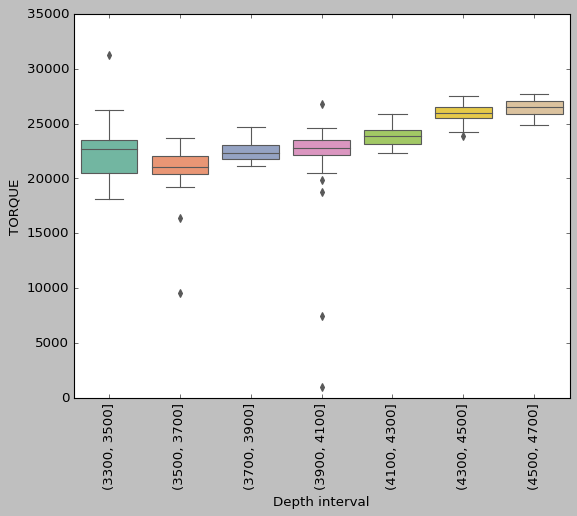

In [ ]:
def boxplot_depth2(df, feature, column_depth, interval):
  """ 
  Boxplot of a given feature per depth interval 
  (Seaborn "Static" style)
  """
  # Ignore copy warning
  import warnings
  from pandas.core.common import SettingWithCopyWarning
  warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

  # Group dataframe by depth intervals
  df1 = df[feature]  
  mind, maxd, inc = min(df[column_depth]), max(df[column_depth])+interval, interval
  x = df1.groupby(pd.cut(df[column_depth], np.arange(mind, maxd, inc)))

  # Get the depth groups
  depth_groups = pd.DataFrame(x).iloc[:,0].astype(str).values  

  df_per_group = []
  for key, item in x:
    y = x.get_group(key)
    y["Interval"] = key
    df_per_group.append(y)
  
  # Concatenate all dataframes
  df_per_group = pd.concat(df_per_group).reset_index(drop=True)
  df_per_group["Interval"] = df_per_group["Interval"].astype(str)

  # Create boxplot
  g = sns.boxplot(x="Interval", y=feature[0], data=df_per_group, 
                  palette="Set2")
  g.set(xlabel=column_depth+" interval")
  g.set_xticklabels(depth_groups, rotation=90)

  ## Plotly Express gives unpleasing result

  # fig = px.box(df_per_group, x="Interval", y=feature[0], color="Interval",
  #              width=700, height=500)
  # fig.update_layout(xaxis=dict(tickangle=90), boxgap=.1, xaxis_visible=False)
  # fig.update_layout(boxgap=.1, xaxis_visible=False)
  # fig.show()

boxplot_depth2(df, ["TORQUE"], "Depth", 200)

#### Group by time interval

In [ ]:
def boxplot_datetime(df, feature, column_time, freq="1D"):
  """ 
  Boxplot of a given feature per time interval 
  (Plotly Go "Interactive" style)
  """
  # Ignore copy warning
  import warnings
  from pandas.core.common import SettingWithCopyWarning
  warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

  # Group dataframe by depth intervals
  df1 = df[feature + [column_time]]
  x = df1.groupby(pd.Grouper(key=column_time, freq=freq))

  # Get the depth groups
  depth_groups = pd.DataFrame(x).iloc[:,0].astype(str).values  

  df_per_group, keys = [], []
  fig = go.Figure() # boxplot using the Plotly Go method, instead of Express

  for key, item in x:
    y = x.get_group(key)
    y["Interval"] = key
    c = np.str(key)

    fig.add_trace(go.Box(y=y[feature].values[:,0], name=c)) # Plotly Go
    fig.update_layout(xaxis_visible=False,
                      title="Boxplot of {} for {} time intervals".format(feature[0], freq))

    df_per_group.append(y)
    keys.append(key)

  fig.show()
  
  # Concatenate all dataframes
  df_per_group = pd.concat(df_per_group).reset_index(drop=True)
  df_per_group["Interval"] = df_per_group["Interval"].astype(str)

boxplot_datetime(df, ["TOTGAS"], "Time", freq="6H")

#### Sidenote: Multiple dataframes in one boxplot.

Multiple dataframes are produced from the pd.groupby

### Pairplot

Pairplot and distributions do not show colors, because the realtime drilling data does not have lithology information. 

In [ ]:
# def normalization(df, trans_features, method="log"):
#   for i in trans_features:
#     if method=="log":
#       df["NORM_"+i] = np.log10(df[i])  
#   return df

def normalize(df, trans_features, method="log"):
  df_norm = df.copy()
  for i in trans_features:
    if method=="log":
      df_norm[i] = np.log10(df[i])  
  return df_norm

def pairplot(df, features, color, normalize=False, trans_features=None):
  fig = px.scatter_matrix(df, dimensions=features, color=color, symbol=color,
                          height=1000, width=1000, title="Scatter Plot Matrix")
  fig.update_traces(showupperhalf=False, diagonal_visible=False)
  fig.show()

# def pairplot(df, features, color, normalize=False, trans_features=None):
#   df = df[features]
#   if normalize==True:
#     df = normalization(df, trans_features, method="log") # df already has new ["NORM_"] features

#     # Change names of features that includes the ["NORM_"] features
#     for i in range(len(features)):
#       for j in range(len(trans_features)):
#         if trans_features[j] == features[i]:
#           features[i] = 'NORM_' + trans_features[j]

#   else:
#     features = features

#   fig = px.scatter_matrix(df, dimensions=features, color=color, symbol=color,
#                           height=1000, width=1000, title="Scatter Plot Matrix")
#   fig.update_traces(showupperhalf=False, diagonal_visible=False)
#   fig.show()

In [ ]:
# features = ['a', 'b', 'c', 'd', 'e']
# trans_features = ['a', 'd']

# for i in range(len(features)):
#   for j in range(len(trans_features)):
#     if trans_features[j] == features[i]:
#       features[i] = 'NORM_' + trans_features[j]

# print(l1)

['NORM_a', 'b', 'c', 'NORM_d', 'e']


In [ ]:
features = ["TORQUE", "ROP_AVG", "WOB", "TOTGAS", "ECDBIT", "SURF_RPM", "MWOUT", "MWIN"]

pairplot(df, features, color=None)

### Distributions 1D KDE plot

To make the KDE distribution PER INTERVAL, there is a trick. See section "Sidenote: Explorting pd.groupby" above. 

In [ ]:
def kde1d(df, features, nrows=3, ncols=3, figsize=(20,10)):
  plt.figure(figsize=figsize)
  for i in range(len(features)):
    plt.subplot(nrows,ncols,i+1)
    sns.kdeplot(df[features[i]])
    plt.title(features[i])
  plt.tight_layout(1.1)
  plt.show()

def kde1d_depth(df, feature, column_depth, interval, nrows=3, ncols=3, figsize=(20,10)):
  """ KDE 1D distribution of a given feature per depth interval """
  # Ignore "Dataset has 0 variance" warning
  import warnings
  warnings.simplefilter("ignore", UserWarning)

  df1 = df[feature]  
  mind, maxd, inc = min(df[column_depth]), max(df[column_depth])+interval, interval

  # Group dataframe by depth intervals
  x = df1.groupby(pd.cut(df[column_depth], np.arange(mind, maxd, inc)))

  # Get the depth groups
  depth_groups = pd.DataFrame(x).iloc[:,0].astype(str).values

  plt.figure(figsize=figsize)
  for i in range(len(feature)):
    plt.subplot(nrows, ncols, i+1)
    plt.title(feature[i])
    # Groups of each feature
    for key, item in x:
      y = x.get_group(key)
      values = y[feature[i]].values 
      sns.kdeplot(values, Label=key)  
      plt.legend(loc="best")

  plt.tight_layout(1.1)    
  # plt.show()

#### In general

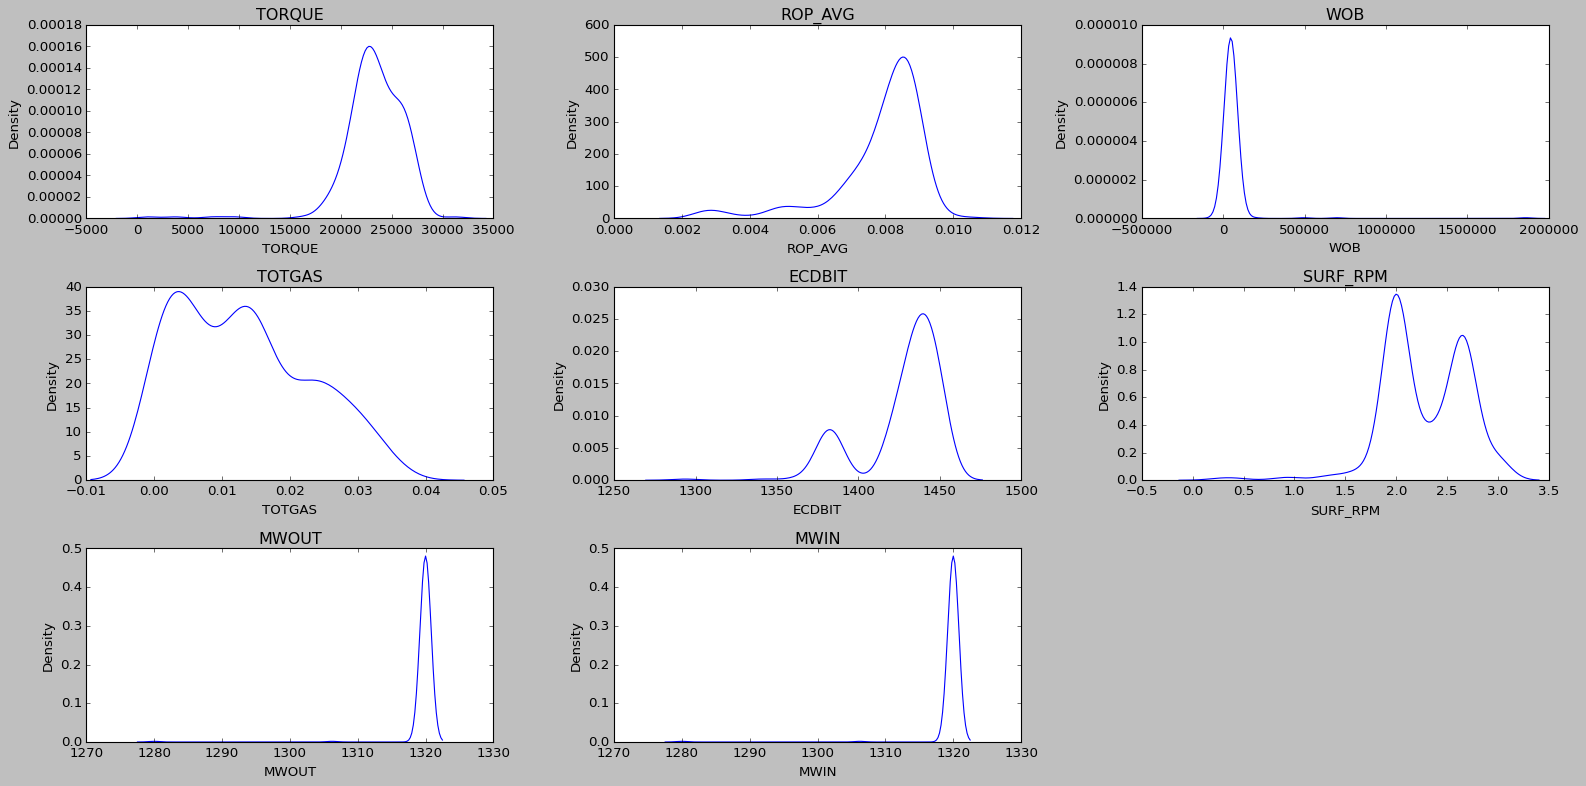

In [ ]:
kde1d(df, features)

#### Group by depth intervals

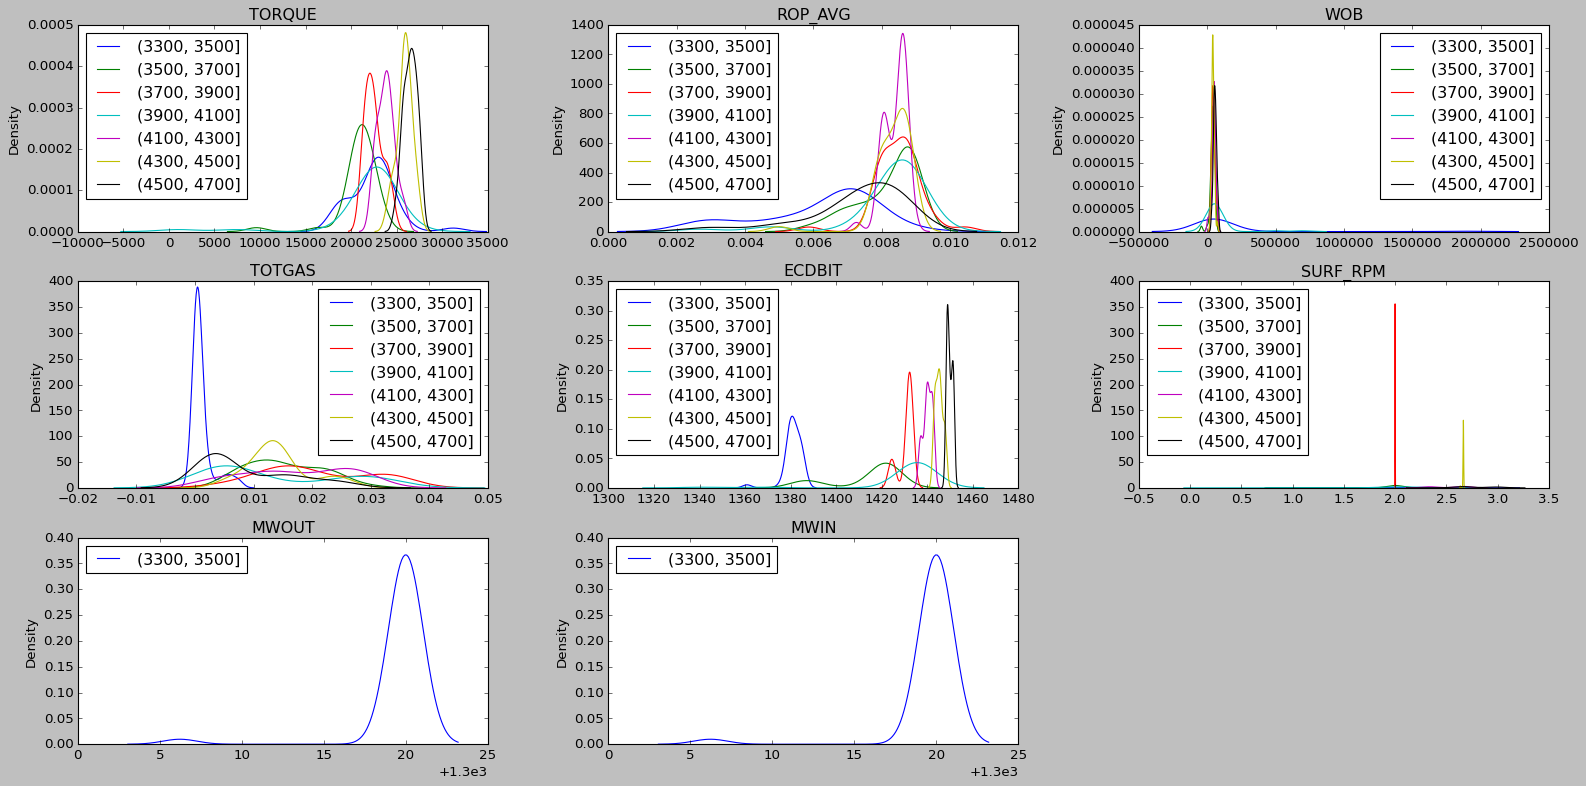

In [ ]:
features = ["TORQUE", "ROP_AVG", "WOB", "TOTGAS", "ECDBIT", "SURF_RPM", "MWOUT", "MWIN"]
kde1d_depth(df, features, "Depth", 200)

Focusing on one feature.

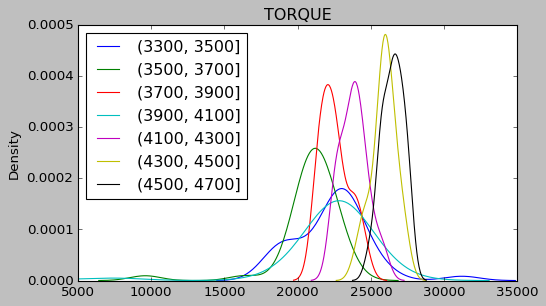

In [ ]:
kde1d_depth(df, ["TORQUE"], "Depth", 200, nrows=1, ncols=1, figsize=(7,4))
plt.xlim(5000, 35000)
plt.show()

Seeing the pattern of TORQUE distribution over depth intervals, as depth is deeper, TORQUE distribution shifts to the LEFT, meaning: TORQUE increases as depth increases. 

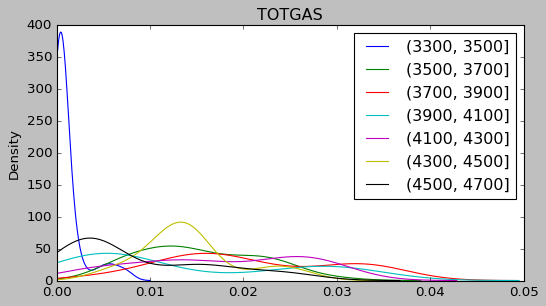

In [ ]:
kde1d_depth(df, ["TOTGAS"], "Depth", 200, nrows=1, ncols=1, figsize=(7,4))
plt.xlim(0, .05)
plt.show()

#### Group by time interval

### 2D scatter plot

In [ ]:
def scatter2d(df, features):
  @interact

  def f(x_axis=features, y_axis=features, color_by=features):
    fig = px.scatter(df, x=x_axis, y=y_axis, color=color_by,
                    marginal_x="histogram", marginal_y="histogram",
                    width=700, height=700)
    fig.show()  

In [ ]:
df_norm = normalize(df, trans_features=["WOB"])

scatter2d(df_norm, features)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

invalid value encountered in log10



interactive(children=(Dropdown(description='x_axis', options=('TORQUE', 'ROP_AVG', 'WOB', 'TOTGAS', 'ECDBIT', …

### 3D scatter plot

In [ ]:
def scatter3d(df, features):
  @interact

  def f(x_axis=features, y_axis=features, z_axis=features):
    fig = px.scatter_3d(df, x=x_axis, y=y_axis, z=z_axis, color=z_axis)
    fig.show()

In [ ]:
scatter3d(df, features)

interactive(children=(Dropdown(description='x_axis', options=('TORQUE', 'ROP_AVG', 'WOB', 'TOTGAS', 'ECDBIT', …

### 2D KDE plot (with probability calculation)

In [ ]:
def kde2d(df, x_axis, y_axis, evaluate_proba=False, xbound=None, ybound=None):
  sns.kdeplot(data=df, x=x_axis, y=y_axis, fill=True, cbar=True, cmap="plasma")
  if evaluate_proba==True:
    plt.vlines(xbound[0], ymin=ybound[0], ymax=ybound[1], color="red")
    plt.vlines(xbound[1], ymin=ybound[0], ymax=ybound[1], color="red")
    plt.hlines(ybound[0], xmin=xbound[0], xmax=xbound[1], color="red")
    plt.hlines(ybound[1], xmin=xbound[0], xmax=xbound[1], color="red")
  plt.title("2D Kernel Density Estimation Plot", pad=20)
  plt.grid()

def compute_proba_1d(df, x, xrange):
  from scipy import stats

  ## Estimate KDE 1D
  kdex = stats.gaussian_kde(df[x])

  ## Integrate 
  Px = kdex.integrate_box(xrange[0], xrange[1])

  return Px

def compute_proba_2d(df, x, y, xrange, yrange):
  from scipy import stats

  # Compute marginal probabilities
  Px = compute_proba_1d(df, x, (xrange[0], xrange[1]))
  Py = compute_proba_1d(df, y, (yrange[0], yrange[1]))

  # Compute joint probabilities
  xmin, xmax = df[x].min(), df[x].max()
  ymin, ymax = df[y].min(), df[y].max()

  ## Estimate KDE 2D, P(xny)
  X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
  positions = np.vstack([X.ravel(), Y.ravel()])
  values = np.vstack([df[x], df[y]])
  kdexy = stats.gaussian_kde(values)  

  ## Integrate
  Pxny = kdexy.integrate_box([xrange[0], yrange[0]], [xrange[1], yrange[1]])

  # Compute conditional probability, or Probability of y given x occured, P(y|x)
  Pxy_cond = Pxny / Px

  return Px, Py, Pxny, Pxy_cond

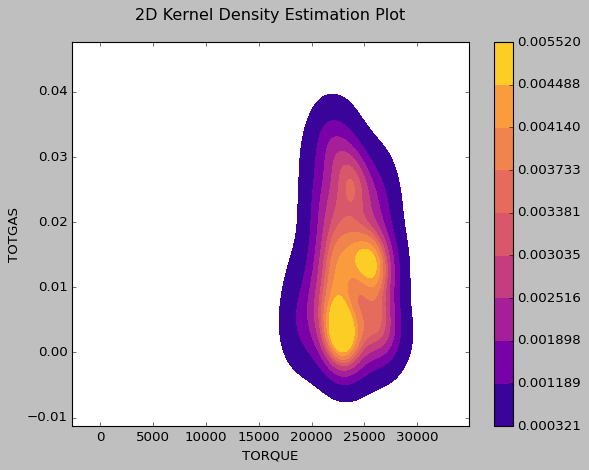

In [ ]:
kde2d(df, "TORQUE", "TOTGAS")

Event A: TORQUE between 20000 and 25000
Event B: TOTGAS between 0.01 and 0.03 

Probability of A is: 0.6266368903545801
Probability of B is: 0.5033814186765965
Probability of A and B occur is: 0.30599339700346784
Probability of B given A occurs is: 0.4883105379102763


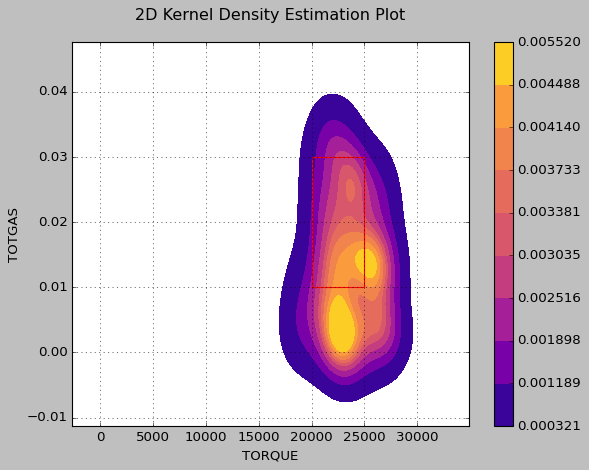

In [ ]:
x, y = "TORQUE", "TOTGAS"
xbound = (20000, 25000) # Bounds where we would like to evaluate probability
ybound = (.01, .03)

# Because dataframe contains NaN, drop NaN
df1 = df.copy()
df1 = df1.dropna(subset=[x, y])

# Compute probabilities
Px, Py, Pxny, Pxy_cond = compute_proba_2d(df1, x, y, xbound, ybound)

# Print statements
print('Event A: {} between {} and {}'.format(x, xbound[0], xbound[1]))
print('Event B: {} between {} and {} \n'.format(y, ybound[0], ybound[1]))
print('Probability of A is: {}'.format(Px))
print('Probability of B is: {}'.format(Py))
print('Probability of A and B occur is: {}'.format(Pxny))
print('Probability of B given A occurs is: {}'.format(Pxy_cond))

# Plot KDE 2D
kde2d(df1, "TORQUE", "TOTGAS", evaluate_proba=True, xbound=xbound, ybound=ybound)

### Visualization on trajectory

In [ ]:
def merge_data_interpolation(df_data, df_new, xdata, ydata, xnew, kind="cubic"):
  """ 
  Merging two data by interpolation 
  
  INPUT:

  df_data: Data source for interpolation 
  df_new: Data where its values are to be interpolated
  xdata: The x column name in df_data. This value MUST exist in BOTH dataframes 
    above. Usually it is the DEPTH. 
  ydata: The y column name in df_data. This value will be the TARGET for interp.
    Could be more than one (LIST)
  xnew: The x column name in df_new
  
  THEORY:

  f(x1, x2, x3, ..., xi) = y1, y2, y3, ..., yi
  f is the interpolation function. f is applied to a new x value to produce new y
  f(xn) = yn 

  OUTPUT:

  df: It is the df_new, but now contains the newly interpolated y values
  """
  xd = df_data[xdata].values
  yd = df_data[ydata].values
  xn = df_new[xnew].values

  # Interpolation
  for i in range(len(ydata)):
    yd_ = yd[:,i]
    f = scipy.interpolate.interp1d(xd, yd_, kind=kind, fill_value="extrapolate")
    yn = f(xn)
    # yn = np.interp(xn, xd, yd_)
    df_new[ydata[i]] = yn # add new column to df_new
  
  df_new[df_new[xnew] > max(xd)] = np.nan

  return df_new

def visualize_data_on_trajectory(df, x, y, z, time, features, hover=None):
  """
  Visualize Log data on Trajectory

  INPUT. df: The merged dataframe that contains x (true Easting), y (true Northing),
  z (TVD), features (logs), and time (datetime in realtime)

  OPTIONAL INPUT. hover: if you want to track log information on the trajectory.
  Specify what features to hover. Default is None.  
  """
  # Convert datetime to string and add new column. This is for hovering data.
  df[time] = df[time].astype(str)

  if hover!=None:
    hover = [time] + hover

  if hover==None:
    hover = [time]
  
  @interact
  def f(color_by=features):
    fig = px.scatter_3d(df, x=x, y=y, z=z,
                        color=color_by, hover_data=hover,
                        width=1100)
    # fig.add_traces(px.line_3d(df, x=x, y=y, z=z))
    fig.update_scenes(zaxis_autorange="reversed")
    fig.show()    

In [ ]:
df_data, df_new = traj_df, df # trajectory and realtime drilling data
xdata, xnew = "md", "Depth"
ydata = ["surfNs", "surfEw", "TVD_calc"]

# Combine trajectory and drilling data into new dataframe
traj_drill_df = merge_data_interpolation(df_data, df_new, xdata, ydata, xnew)

traj_drill_df.tail()

,Depth,LAGMWT,Time,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,surfNs,surfEw,TVD_calc
273,4665.0,1320.0,2013-12-01 10:14:40,0.0,27075.188,0.0,1.800578,1320.0,0.0,1320.0,2.994254,0.987674,4646.0212,22818638.0,303.15,111.0,0.0,0.041173,0.008648,0.0,0.002190,0.0,303.15,0.0,0.039883,31494.846,184072.0,1451.4642,0.0,1365.9964,2.993031,-303.15,6.478722e+06,436631.502162,3208.718741
274,4670.0,1320.0,2013-12-01 10:24:18,0.0,27096.219,0.0,1.800000,1320.0,0.0,1320.0,2.995872,0.987674,4650.4826,24994158.0,303.15,111.0,0.0,0.040584,0.008645,0.0,0.002631,0.0,303.15,0.0,0.039870,50567.593,184650.0,1451.5601,0.0,1370.9935,2.995281,-303.15,6.478721e+06,436636.199689,3209.582987
275,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
features = ["TORQUE", "ROP_AVG", "WOB", "TOTGAS", "ECDBIT", "SURF_RPM", "MWOUT", "MWIN"]

visualize_data_on_trajectory(traj_drill_df, "surfEw", "surfNs", "TVD_calc", "Time",
                             features=features, hover=["TORQUE"])

interactive(children=(Dropdown(description='color_by', options=('TORQUE', 'ROP_AVG', 'WOB', 'TOTGAS', 'ECDBIT'…

### Dashboard 1: Trajectory, time-series plot, boxplot, and 1D KDE

In [ ]:
def kde1d_depth(df, feature, column_depth, interval):
  """ KDE 1D distribution of a given feature per depth interval """
  # Ignore "Dataset has 0 variance" warning
  import warnings
  warnings.simplefilter("ignore", UserWarning)

  from scipy import stats

  df1 = df[[feature]]  
  mind, maxd, inc = min(df[column_depth]), max(df[column_depth])+interval, interval

  # Group dataframe by depth intervals
  x = df1.groupby(pd.cut(df[column_depth], np.arange(mind, maxd, inc)))

  # Get the depth groups
  depth_groups = pd.DataFrame(x).iloc[:,0].astype(str).values

  fig = go.Figure()
  for key, item in x:
    y = x.get_group(key)
    xd = y[[feature]].values
    xd = xd[~np.isnan(xd)]
    kdex = stats.gaussian_kde(xd)
    xp = np.linspace(min(df[feature]), max(df[feature]), 100)

    fig.add_trace(go.Scatter(x=xp, y=kdex(xp)))

  # fig.show()    

kde1d_depth(df, "ROP_AVG", "Depth", 200)

In [ ]:
def kde1d_plotly(df, x):
  from scipy import stats
  xd = df[x].values
  xd = xd[~np.isnan(xd)]
  kdex = stats.gaussian_kde(xd)
  xp = np.linspace(min(xd), max(xd), 100)
  # fig = px.line(x=xp, y=kdex(xp))

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=xp, y=kdex(xp)))

  fig.show()

kde1d_plotly(df, "ROP_AVG")

In [ ]:
def kde1d_plotly(df, x):
  from scipy import stats
  xd = df[x].values
  xd = xd[~np.isnan(xd)]
  kdex = stats.gaussian_kde(xd)
  xp = np.linspace(min(xd), max(xd), 100)
  # fig = px.line(x=xp, y=kdex(xp))

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=xp, y=kdex(xp)))

  fig.show()

kde1d_plotly(df, "ROP_AVG")

In [ ]:
def kde1d_depth(df, feature, column_depth, interval, row=1, col=1):
  """ KDE 1D distribution of a given feature per depth interval """
  # Ignore "Dataset has 0 variance" warning
  import warnings
  warnings.simplefilter("ignore", UserWarning)

  from scipy import stats

  df1 = df[[feature]]  
  mind, maxd, inc = min(df[column_depth]), max(df[column_depth])+interval, interval

  # Group dataframe by depth intervals
  x = df1.groupby(pd.cut(df[column_depth], np.arange(mind, maxd, inc)))

  # Get the depth groups
  depth_groups = pd.DataFrame(x).iloc[:,0].astype(str).values

  # fig = go.Figure()
  for key, item in x:
    y = x.get_group(key)
    xd = y[[feature]].values
    xd = xd[~np.isnan(xd)]
    kdex = stats.gaussian_kde(xd)
    xp = np.linspace(min(df[feature]), max(df[feature]), 100)

    fig.add_trace(go.Scatter(x=xp, y=kdex(xp)),
                  row=row, col=col)
    return fig

  # fig.show()    

In [ ]:
df_trajectory = traj_df

feature = ["ROP_AVG", "TORQUE", "WOB", "TOTGAS", "ECDBIT", "SURF_RPM", "MWOUT", "MWIN"]
column_time = "Time"
column_depth, interval = "Depth", 200
# freq = "6H"

from plotly.subplots import make_subplots
from scipy import stats

@interact

def f(Feature=feature, Frequency=["6H", "12H", "24H"]): # 2H and 4H give error. That's weird.
  fig = make_subplots(
      rows = 3, cols = 6,
      specs=[
            [{"type": "Scatter3d", "rowspan": 3, "colspan": 2}, None, {"type": "box", "rowspan": 1, "colspan": 2}, None, {"type": "Scatter", "rowspan": 1, "colspan": 2}, None],
            [None, None, {"type": "scatter", "rowspan": 2, "colspan": 4}, None, None, None],
            [None, None, None, None, None, None]
            
      ],
      subplot_titles=["{} on trajectory".format(Feature), 
                      "Boxplot of {} for {} time intervals".format(Feature, Frequency), 
                      "Distplot of {} for {} time intervals".format(Feature, Frequency), 
                      "Timeseries"]
  )

  # Set dark theme
  fig.update_layout(xaxis_visible=False, showlegend=False, template="plotly_dark")

  # Title setting
  for i in fig['layout']['annotations']:
      i['font'] = dict(size=14)

  # # Dropdown menu
  # fig.update_layout(
  #     updatemenus=[
  #         dict(
  #             buttons=list([
  #                 dict(
  #                     args=["type", "surface"],
  #                     label="3D Surface",
  #                     method="restyle"
  #                 ),
  #                 dict(
  #                     args=["type", "heatmap"],
  #                     label="Heatmap",
  #                     method="restyle"
  #                 )
  #             ]),
  #             direction="down",
  #             pad={"r": 10, "t": 10},
  #             showactive=True,
  #             x=0.1,
  #             xanchor="left",
  #             y=1.1,
  #             yanchor="top"
  #         ),
  #     ]
  # )    

  # Trajectory visualization
  x, y, z = df_trajectory["surfEw"].values, df_trajectory["surfNs"].values, df_trajectory["TVD_calc"].values

  fig.add_trace(
      go.Scatter3d(
          x=x, y=y, z=z, mode="markers", marker_color=z,
          ),
      row=1, col=1
  )


  fig.update_scenes(zaxis_autorange="reversed")

  # Timeseries plot
  x, y = df[column_time], df[Feature].values

  cont_color = ["blue", "green", "red", "yellow"]  
  fig.add_trace(
      go.Scatter(
          x=x, y=y, mode="lines+markers", marker_color=y
      ),
      row=2, col=3
  )

  # Boxplot per time interval

  """ This script is taken part of "boxplot_datetime" function """
  def datetime_grouper(df, feature, column_time, freq="1D"):
    import warnings
    from pandas.core.common import SettingWithCopyWarning
    warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

    ## Group dataframe by depth intervals
    df1 = df[[Feature] + [column_time]]
    return df1.groupby(pd.Grouper(key=column_time, freq=freq))

  x = datetime_grouper(df, Feature, column_time, freq=Frequency)

  # import warnings
  # from pandas.core.common import SettingWithCopyWarning
  # warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

  # ## Group dataframe by depth intervals
  # df1 = df[[Feature] + [column_time]]
  # x = df1.groupby(pd.Grouper(key=column_time, freq=freq))

  ## Get the depth groups
  depth_groups = pd.DataFrame(x).iloc[:,0].astype(str).values  

  df_per_group, keys = [], []

  for key, item in x:
    y = x.get_group(key)
    y["Interval"] = key
    c = np.str(key)

    """ Script for plotting boxplots with go """
    fig.add_trace(
        go.Box(
            y=y[[Feature]].values[:,0], name=c
            ),
            row=1, col=3
    ) 

    # fig.update_layout(xaxis_visible=False, showlegend=False, template="plotly_dark")

  # Distplot per time interval
  for key, item in x:
    y = x.get_group(key)
    xd = y[[Feature]].values
    xd = xd[~np.isnan(xd)]
    kdex = stats.gaussian_kde(xd)
    xp = np.linspace(min(df[Feature]), max(df[Feature]), 100)

    fig.add_trace(go.Scatter(x=xp, y=kdex(xp), name=np.str(key)),
                  row=1, col=5)  
    
  # feature = "ROP_AVG"
  # fig = kde1d_depth(df, Feature, column_depth, interval, row=1, col=5)

  fig.update_layout(width=1100, height=500)

  fig.show()

interactive(children=(Dropdown(description='Feature', options=('ROP_AVG', 'TORQUE', 'WOB', 'TOTGAS', 'ECDBIT',…

### Dashboard 2: Log display, 2D, 3D scatter plots, 

In [ ]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "bar"}, {"type": "barpolar"}],
           [None, {"type": "box"}]],
)

# Set dark theme
fig.update_layout(xaxis_visible=False, showlegend=False, template="plotly_dark")

fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "bar"}, {"type": "barpolar"}],
           [{"type": "pie"}, {"type": "box"}]],
)

# Set dark theme
fig.update_layout(xaxis_visible=False, showlegend=False, template="plotly_dark")

fig.add_trace(go.Bar(y=[2, 3, 1]),
              row=1, col=1)

fig.add_trace(go.Barpolar(theta=[0, 45, 90], r=[2, 3, 1]),
              row=1, col=2)

fig.add_trace(go.Pie(values=[2, 3, 1]),
              row=2, col=1)

# fig.add_trace(go.Scatter3d(x=[2, 3, 1], y=[0, 0, 0],
#                            z=[0.5, 1, 2], mode="lines"),
#               row=2, col=2)

y0 = np.random.randn(50)
y1 = np.random.randn(50) + 1 # shift mean


a, b = [y0, y1], ["sample A", "sample B"]

fig.add_trace(go.Box(y=y0, name='Sample A',
                marker_color = 'indianred'),
              row=2, col=2)
fig.add_trace(go.Box(y=y1, name = 'Sample B',
                marker_color = 'lightseagreen'),
              row=2, col=2)

fig.update_layout(height=700, showlegend=False)

fig.show()

# LWD Data

## Open file

In well 15/9-F-15, there are two runs. It requires to open the multiple files.

In [ ]:
def open_multiple_las_files(folder, inspect=False):
  # Glob files
  paths = glob_files(folder, ".las")

  # Inspect, otherwise open
  if inspect == True:
    lognames_list, descr_list, unit_list = [], [], []
    for i in range(len(paths)):
      # Reading the LAS file
      data = lasio.read(paths[i])
      
      # Log names
      lognames = [data.curves[i].mnemonic for i in range(len(data.curves))]
      # descr = [data.curves[i].descr for i in range(len(data.curves))]
      # unit = [data.curves[i].unit for i in range(len(data.curves))]

      lognames_list.append(lognames)  
      # descr_list.append(descr)
      # unit_list.append(unit)  

      # Print how many mnemonics/columns each dataframe has
      print("Dataframe {} has {} mnemonics".format(i+1, len(lognames)))

    all_lognames = np.concatenate(lognames_list, axis=0)
    all_lognames = np.unique(all_lognames)

    # all_descr = np.concatenate(descr_list, axis=0)
    # all_descr = np.unique(all_descr)

    # all_unit = np.concatenate(unit_list, axis=0)
    # all_unit = np.unique(all_unit)        

    # Check the availability of each mnemonic in each dataframes
    availability = []
    for i in all_lognames:
      avail_per_df = []
      for j in lognames_list:
        avail = np.any(np.array(j) == i)
        avail_per_df.append(avail)

      availability.append(avail_per_df)
    
    # Create availability dataframe
    columns = np.arange(1,len(paths)+1).astype(str)
    avail_df = pd.DataFrame(availability, columns=columns, index=all_lognames)

    # List mnemonics
    # avail_df['Unit'] = all_unit
    # avail_df['Description'] = all_descr

    # Identify which mnemonics are available in all dataframes
    available = avail_df.all(axis=1).values
    available = all_lognames[available]
    print("\n")
    print("Mnemonics exists in ALL dataframes:")
    print(*('"{}"'.format(item) for item in available), sep=', ')    

    # Print the availability dataframe
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    print(avail_df)

  else:
    # Inspect=False, open the file with selected log names   
    dataframes = []
    for i in range(len(paths)):
      # Reading the LAS file
      data = lasio.read(paths[i])
      df = data.df().reset_index() 

      # Subset of dataframe
      # df = df[selected_logs]     

      # Append all dataframes
      dataframes.append(df)

    # Concatenate all individual dataframes
    df = pd.concat(dataframes, axis=0).reset_index(drop=True)

    # Replace blank values with nan
    df = df.replace('', np.NaN)    
  
    return df

def list_mnemonics(lasfile):
  """
  List all available mnemonics and descriptions. 
  Outputs are in dictionary and dataframe
  """
  mnemonic_array, descr_array = [], []
  for i in range(len(lasfile.curves[:])):
    mnemonic = lasfile.curves[i].mnemonic
    descr = lasfile.curves[i].descr
    mnemonic_array.append(mnemonic)
    descr_array.append(descr)

  # Create into dictionary
  mnemonic_dict = dict(zip(mnemonic_array, descr_array))  

  return mnemonic_dict, mnemonic_df

In [ ]:
folder = "/content/geostatistics/data/volve-realtime/well_15_9_F-15"

open_multiple_las_files(folder, inspect=True)

Dataframe 1 has 424 mnemonics
Dataframe 2 has 472 mnemonics


Mnemonics exists in ALL dataframes:
"6TIM", "A112", "A114", "A122", "A124", "A132", "A134", "A142", "A144", "A152", "A154", "A16H", "A16H_COND", "A16L", "A16L_COND", "A212", "A214", "A222", "A224", "A22H", "A22H_COND", "A22L", "A22L_COND", "A232", "A234", "A242", "A244", "A252", "A254", "A28H", "A28H_COND", "A28L", "A28L_COND", "A34H", "A34H_COND", "A34L", "A34L_COND", "A40H", "A40H_COND", "A40L", "A40L_COND", "ASAL_WALK2", "BCAV", "BCHO", "BCVE", "BPHB", "BPHB_UNC", "BPHI", "BPHI_UNC", "BPHL", "BPHL_UNC", "BPHR", "BPHR_UNC", "BPHU", "BPHU_UNC", "BS_ARC", "CCA_WALK2", "CCHL_WALK2", "CFE_WALK2", "CGD_WALK2", "CHY_WALK2", "CK_WALK2", "CNC_WALK2", "CRPM", "CSI_WALK2", "CSUL_WALK2", "CSUU_WALK2", "CTI_WALK2", "DBPHB", "DBPHI", "DBPHL", "DBPHR", "DBPHU", "DCAV", "DCHO", "DCVE", "DEVI", "DHAP", "DHAT", "DRHB", "DRHL", "DRHO", "DRHR", "DRHU", "DRSC[0]", "DRSC[10]", "DRSC[11]", "DRSC[12]", "DRSC[13]", "DRSC[14]", "DRSC[15]", "DRSC[1

In [ ]:
folder = "/content/geostatistics/data/volve-realtime/well_15_9_F-15"

df = open_multiple_las_files(folder, inspect=False)

df.head(10)

,TDEP,6TIM,ROP5_RM,RFSA,RFSB,RFSL,RFSU,RFSR,QC_SIGM,QC_SPEC,WANH,WCLA,WCAR,WQFM,WPYR,WSID,WCOA,WEVA,CHY_WALK2,CSI_WALK2,CCA_WALK2,CCHL_WALK2,CFE_WALK2,CSUU_WALK2,CGD_WALK2,CTI_WALK2,CNC_WALK2,CK_WALK2,DWSI_WALK2,DWCA_WALK2,DWFE_WALK2,DWSU_WALK2,DWTI_WALK2,DWGD_WALK2,DWAL_WALK2,ASAL_WALK2,FY2W_WALK2,DXFE_WALK2,TAB_SPC,SIFA,SIFB,SIFL,SIFU,SIFR,CSUL_WALK2,SAZ1[0],SAZ1[1],SAZ1[2],SAZ1[3],SAZ1[4],SAZ1[5],SAZ1[6],SAZ1[7],SAZ1[8],SAZ1[9],SAZ1[10],SAZ1[11],SAZ1[12],SAZ1[13],SAZ1[14],SAZ1[15],SAZ2[0],SAZ2[1],SAZ2[2],SAZ2[3],SAZ2[4],SAZ2[5],SAZ2[6],SAZ2[7],SAZ2[8],SAZ2[9],SAZ2[10],SAZ2[11],SAZ2[12],SAZ2[13],SAZ2[14],SAZ2[15],LSAZ[0],LSAZ[1],LSAZ[2],LSAZ[3],LSAZ[4],LSAZ[5],LSAZ[6],LSAZ[7],LSAZ[8],LSAZ[9],LSAZ[10],LSAZ[11],LSAZ[12],LSAZ[13],LSAZ[14],LSAZ[15],RLSC[0],RLSC[1],RLSC[2],RLSC[3],RLSC[4],RLSC[5],RLSC[6],RLSC[7],RLSC[8],RLSC[9],RLSC[10],RLSC[11],RLSC[12],RLSC[13],RLSC[14],RLSC[15],RSSC[0],RSSC[1],RSSC[2],RSSC[3],RSSC[4],RSSC[5],RSSC[6],RSSC[7],RSSC[8],RSSC[9],RSSC[10],RSSC[11],RSSC[12],RSSC[13],RSSC[14],RSSC[15],ROSC[0],ROSC[1],ROSC[2],ROSC[3],ROSC[4],ROSC[5],ROSC[6],ROSC[7],ROSC[8],ROSC[9],ROSC[10],ROSC[11],ROSC[12],ROSC[13],ROSC[14],ROSC[15],DRSC[0],DRSC[1],DRSC[2],DRSC[3],DRSC[4],DRSC[5],DRSC[6],DRSC[7],DRSC[8],DRSC[9],DRSC[10],DRSC[11],DRSC[12],DRSC[13],DRSC[14],DRSC[15],PESC[0],PESC[1],PESC[2],PESC[3],PESC[4],PESC[5],PESC[6],PESC[7],PESC[8],PESC[9],PESC[10],PESC[11],PESC[12],PESC[13],PESC[14],PESC[15],USC[0],USC[1],USC[2],USC[3],USC[4],USC[5],USC[6],USC[7],USC[8],USC[9],USC[10],USC[11],USC[12],USC[13],USC[14],USC[15],TAB_DEN,ROLU,ROLR,ROLB,ROLL,RHOL,ROSU,ROSR,ROSB,ROSL,RHOS,ROBU,ROBR,ROBB,ROBL,RHOB,DRHU,DRHR,DRHB,DRHL,DRHO,PEU,PER,PEB,PEL,PEF,UU,UR,UB,UL,U,DSOU,DSOL,DSOR,DSOB,DCHO,DCVE,DCAV,CRPM,QC_RHOB,QC_PEF,GRIQ_FILT[0],GRIQ_FILT[1],GRIQ_FILT[2],GRIQ_FILT[3],GRIQ_FILT[4],GRIQ_FILT[5],GRIQ_FILT[6],GRIQ_FILT[7],GRIQ_FILT[8],GRIQ_FILT[9],GRIQ_FILT[10],GRIQ_FILT[11],GRIQ_FILT[12],GRIQ_FILT[13],GRIQ_FILT[14],GRIQ_FILT[15],TAB_GR,RGRA,GRMA_FILT,GRMA,RGRU,GRMU_FILT,RGRL,GRML_FILT,RGRB,GRMB_FILT,RGRR,GRMR_FILT,QC_GR,UCAL1,UCAL2,UCAL3,UCAL4,UCAL5,UCAL6,UCAL7,UCAL8,EFR1,EFR2,UCAV,UCVE,UCHO,QC_UCAL,TAB_UCAL,DEVI,VIB_X,BCAV,BCVE,BCHO,P1NO,P1AZ,HAZI,TTEM,TAB_ARC_RES,A16H,A22H,A28H,A34H,A40H,P16H,P22H,P28H,P34H,P40H,A16L,A22L,A28L,A34L,A40L,P16L,P22L,P28L,P34L,P40L,A16H_COND,A22H_COND,A28H_COND,A34H_COND,A40H_COND,P16H_COND,P22H_COND,P28H_COND,P34H_COND,P40H_COND,A16L_COND,A22L_COND,A28L_COND,A34L_COND,A40L_COND,P16L_COND,P22L_COND,P28L_COND,P34L_COND,P40L_COND,A112,A212,A122,A222,A132,A232,A142,A242,A152,A252,A114,A214,A124,A224,A134,A234,A144,A244,A154,A254,P112,P212,P122,P222,P132,P232,P142,P242,P152,P252,P114,P214,P124,P224,P134,P234,P144,P244,P154,P254,BS_ARC,QC_RXO,QC_FRT,QC_RES,DHAP,DHAT,ECD,TAB_DHAP,GX_CAL,GX_TEMP,INCL_CONT,NER1,NER2,NER1B,NER2B,NER1L,NER2L,NER1U,NER2U,NER1R,NER2R,FAR1,FAR2,FAR1B,FAR2B,FAR1L,FAR2L,FAR1U,FAR2U,FAR1R,FAR2R,TNPH,TNPB,TNPL,TNPU,TNPR,BPHI,BPHB,BPHL,BPHU,BPHR,TNPH_UNC,TNPB_UNC,TNPL_UNC,TNPU_UNC,TNPR_UNC,BPHI_UNC,BPHB_UNC,BPHL_UNC,BPHU_UNC,BPHR_UNC,DBPHI,DBPHB,DBPHL,DBPHU,DBPHR,QC_BPHI,QC_TNPH,TAB_NEU,MONT,USOI_FILT[0],USOI_FILT[1],USOI_FILT[2],USOI_FILT[3],USOI_FILT[4],USOI_FILT[5],USOI_FILT[6],USOI_FILT[7],USOI_FILT[8],USOI_FILT[9],USOI_FILT[10],USOI_FILT[11],USOI_FILT[12],USOI_FILT[13],USOI_FILT[14],USOI_FILT[15],DCRA[0],DCRA[1],DCRA[2],DCRA[3],DCRA[4],DCRA[5],DCRA[6],DCRA[7],DCRA[8],DCRA[9],DCRA[10],DCRA[11],DCRA[12],DCRA[13],DCRA[14],DCRA[15],GR_IMG16_FILT[0],GR_IMG16_FILT[1],GR_IMG16_FILT[2],GR_IMG16_FILT[3],GR_IMG16_FILT[4],GR_IMG16_FILT[5],GR_IMG16_FILT[6],GR_IMG16_FILT[7],GR_IMG16_FILT[8],GR_IMG16_FILT[9],GR_IMG16_FILT[10],GR_IMG16_FILT[11],GR_IMG16_FILT[12],GR_IMG16_FILT[13],GR_IMG16_FILT[14],GR_IMG16_FILT[15]
0,8284.0,7197450.0,19.6651,33.2073,31.0818,31.5009,34.1345,35.1409,0.0,0.696035,0.0,72.9994,1.68169,23.4180,0.000000,1.90089,0.0,0.0,4.94545,13.1697,3.718180,16.7303,34.9698,-0.893939,6.27273,-1.124240,12.2545,0.0,19.4644,3.413270,8.52876,0.000000,0.000000,3.19686,12.4908,53.1869,1.477

Non-azimuthal logs: TDEP,	GRMA,	BCAV,	WCLA,	WCAR,	WQFM,	RHOB,	BPHI,	PEF,	BS_ARC




In [ ]:
lwd_df = df[["TDEP", "GRMA", "BCAV", "WCLA", "WCAR", "WQFM", 
             "RHOB", "BPHI", "PEF", "BS_ARC"]]

lwd_df.head(10)

,TDEP,GRMA,BCAV,WCLA,WCAR,WQFM,RHOB,BPHI,PEF,BS_ARC
0,8284.0,29.6139,15.1446,72.9994,1.68169,23.4180,2.03128,49.2305,60.3361,8.5
1,8284.5,30.2355,15.1291,74.1390,0.00000,23.2063,2.00606,46.3261,61.3447,8.5
2,8285.0,31.8206,14.0747,74.7036,0.00000,21.3821,2.01147,45.3416,58.5946,8.5
3,8285.5,30.4889,15.2500,73.9052,0.00000,21.1337,2.00483,49.8758,60.2625,8.5
4,8286.0,30.0100,15.2500,70.8281,0.00000,22.4436,2.04901,52.4629,60.5356,8.5
5,8286.5,28.7089,15.2500,69.7660,0.00000,23.2428,2.03329,49.5419,61.9171,8.5
6,8287.0,29.3032,14.6620,70.5169,0.00000,22.9830,1.98711,48.5399,61.2396,8.5
7,8287.5,31.0996,13.2824,71.2010,0.00000,22.4536,1.92967,45.2749,63.3063,8.5
8,8288.0,31.5022,13.6347,71.3486,0.02440,22.3971,1.95000,46.8806,63.4265,8.5
9,8288.5,31.7451,13.5447,72.0023,0.00000,21.7054,1.97784,44.1860,62.9736,8.5


## Summary statistics

## Azimuthal logs

Azimuthal logs: "RLSC", "RSSC", "ROSC", "PESC", "USC", "GRIQ_FILT"

In [ ]:
"""
This is the full script I made to extract all the azimuthal log columns
"""

azi = np.arange(16).astype(str)
bracket0, bracket1 = np.full(16,'['), np.full(16,']')
log = ["RLSC", "RSSC", "ROSC", "PESC", "USC", "GRIQ_FILT"]

# Make names
logs = []
for i in range(len(log)):
  logs_ = []
  for j in range(len(azi)):
    _ = log[i] + bracket0[j] + azi[j] + bracket1[j]
    logs_.append(_)
  logs.append(logs_)

# Subset of dataframe
azi_logs = np.array(logs).flatten()

lwd_azi_df = df[azi_logs]
lwd_azi_df.head(10)

,RLSC[0],RLSC[1],RLSC[2],RLSC[3],RLSC[4],RLSC[5],RLSC[6],RLSC[7],RLSC[8],RLSC[9],RLSC[10],RLSC[11],RLSC[12],RLSC[13],RLSC[14],RLSC[15],RSSC[0],RSSC[1],RSSC[2],RSSC[3],RSSC[4],RSSC[5],RSSC[6],RSSC[7],RSSC[8],RSSC[9],RSSC[10],RSSC[11],RSSC[12],RSSC[13],RSSC[14],RSSC[15],ROSC[0],ROSC[1],ROSC[2],ROSC[3],ROSC[4],ROSC[5],ROSC[6],ROSC[7],ROSC[8],ROSC[9],ROSC[10],ROSC[11],ROSC[12],ROSC[13],ROSC[14],ROSC[15],PESC[0],PESC[1],PESC[2],PESC[3],PESC[4],PESC[5],PESC[6],PESC[7],PESC[8],PESC[9],PESC[10],PESC[11],PESC[12],PESC[13],PESC[14],PESC[15],USC[0],USC[1],USC[2],USC[3],USC[4],USC[5],USC[6],USC[7],USC[8],USC[9],USC[10],USC[11],USC[12],USC[13],USC[14],USC[15],GRIQ_FILT[0],GRIQ_FILT[1],GRIQ_FILT[2],GRIQ_FILT[3],GRIQ_FILT[4],GRIQ_FILT[5],GRIQ_FILT[6],GRIQ_FILT[7],GRIQ_FILT[8],GRIQ_FILT[9],GRIQ_FILT[10],GRIQ_FILT[11],GRIQ_FILT[12],GRIQ_FILT[13],GRIQ_FILT[14],GRIQ_FILT[15]
0,3.06702,3.08881,3.09998,3.12051,3.14408,3.19383,3.16941,3.15765,3.08284,3.16673,3.13703,3.06867,3.07631,3.06729,3.05174,3.05691,5.21997,5.22783,5.22139,5.26699,5.59465,5.67298,5.44789,5.42471,5.22557,5.18956,5.18996,5.11148,4.97126,4.97513,5.03889,5.06797,1.97668,2.00955,2.03460,2.03533,1.79944,1.82289,1.97604,1.97390,2.00062,2.17703,2.12459,2.06391,2.17967,2.16152,2.08858,2.07599,64.0730,65.2724,61.7547,55.1098,70.2982,70.4080,76.0077,62.7664,53.6124,60.0033,50.7877,54.0404,54.8643,54.7441,57.2535,57.0776,129.593,134.024,128.246,114.484,130.544,132.291,153.687,126.788,109.635,132.593,109.7410,113.705,121.373,120.178,121.785,120.740,29.8533,28.4037,26.9542,25.5046,24.0551,24.4562,24.8574,25.2586,25.6597,26.8525,28.0454,29.2382,30.4310,30.2866,30.1421,29.9977
1,3.12218,3.11699,3.12959,3.09815,3.11959,3.11850,3.15367,3.08167,3.05672,3.10856,3.11698,3.04667,3.06174,3.05122,3.04029,3.08272,5.29938,5.28052,5.25502,5.23951,5.45290,5.46473,5.35889,5.30344,5.11715,5.13658,5.12058,5.14183,5.08027,5.12957,5.26090,5.22778,2.01241,2.01820,2.06106,2.01702,1.87932,1.86699,2.02116,1.93560,2.03855,2.11495,2.14162,2.00180,2.07527,2.01932,1.89517,1.99866,67.9319,64.2861,60.2213,57.1787,63.0035,70.3709,64.3750,56.6714,51.7479,61.2782,45.6376,57.0121,60.7584,62.4285,68.4947,60.8706,139.666,132.518,126.550,117.804,121.700,135.121,132.879,112.448,107.656,131.857,99.3386,116.650,128.485,128.754,133.321,124.366,42.5530,38.0234,33.4937,28.9641,24.4344,24.9206,25.4067,25.8929,26.3790,26.8609,27.3427,27.8245,28.3063,31.8680,35.4297,38.9913
2,3.13560,3.11369,3.12613,3.10602,3.11068,3.09946,3.13133,3.06353,3.06855,3.09757,3.10062,3.04837,3.07540,3.07830,3.05718,3.07602,5.46609,5.50474,5.50171,5.41069,5.46409,5.37438,5.27104,5.20431,4.99809,4.97416,4.93726,4.95705,4.92486,5.05171,5.27133,5.36933,1.89776,1.82273,1.84886,1.89039,1.85290,1.90911,2.05152,1.98287,2.14728,2.21384,2.24458,2.14201,2.21053,2.12522,1.91736,1.87009,77.4711,70.9137,66.4527,65.5877,64.3429,65.3943,56.1229,54.6222,48.0133,53.5611,44.8088,49.5736,54.2057,59.2476,68.0279,69.6434,150.980,133.230,126.471,127.370,122.699,128.138,117.438,110.794,104.764,120.199,101.8450,107.924,121.478,128.056,133.823,133.925,28.9205,29.4890,30.0576,30.6261,31.1947,30.0047,28.8147,27.6247,26.4347,27.5007,28.5667,29.6327,30.6987,30.2541,29.8096,29.3650
3,3.15238,3.14848,3.20141,3.13726,3.10850,3.09268,3.14463,3.04973,3.05717,3.08475,3.05761,3.02999,3.03972,3.05304,3.05731,3.07220,5.34296,5.47084,5.56788,5.53227,5.45094,5.41835,5.38367,5.37217,5.20483,5.09666,5.00314,4.91756,4.89461,4.91281,5.03319,5.15773,2.03178,1.91767,1.93217,1.84276,1.86030,1.85901,1.98429,1.81884,1.97105,2.10322,2.12483,2.13855,2.17109,2.18104,2.10243,2.03477,65.6083,65.9357,64.7922,76.2082,70.7892,66.2027,58.1855,63.1725,55.2048,53.3863,48.5973,49.6395,52.5156,54.0926,59.5917,60.6263,136.076,129.726,128.354,144.603,135.481,126.623,118.099,118.456,111.366,114.289,105.0190,107.907,115.756,119.734,127.531,125.912,33.5678,32.1372,30.7066,29.2760,27.8454,28.1976,28.5498,28.9020,29.2542,31.3394,33.4246,35.5097,37.5949,36.5881,35.5814,34.5746
4,3.09114,3.10873,3.18430,3.15569,3.13030,3.1085

# Integration with Marker Data

## Report

In [ ]:
well = "15/9 F-15"

y = "WELL {} ANALYTICS \n \n".format(well)
y += "1. TRAJECTORY \n\n"

visualize_trajectory(traj_df, "surfEw", "surfNs", "TVD_calc")

print(y)

WELL 15/9 F-15 ANALYTICS 
 
1. TRAJECTORY 


